# Evolocity of influenza A nucleoprotein

Here, we will walk through the steps for running an evolocity analysis on nucleoprotein sequences as described in our paper.

First, we will need to install [scanpy](https://scanpy.readthedocs.io/) and [evolocity](https://github.com/brianhie/evolocity):

In [ ]:
!pip install scanpy evolocity

Now, import the necessary packages

In [13]:
import evolocity as evo
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

We have provided the nucleoprotein sequences, and their corresponding language model embeddings, within an [AnnData](https://anndata.readthedocs.io/) object, which is a convenient way to store high-dimensional biological data.

We have also already constructed the nearest neighbors graph, which we used to learn a two-dimensional [UMAP](https://umap-learn.readthedocs.io/) embedding and perform graph-based Louvain clustering. We have also provided the associated metadata including subtype and sampling year.

In [6]:
adata = evo.datasets.nucleoprotein()
adata

AnnData object with n_obs × n_vars = 3304 × 1280
    obs: 'n_seq', 'seq', 'gene_id', 'embl_id', 'subtype', 'year', 'date', 'country', 'host', 'resist_adamantane', 'resist_oseltamivir', 'virulence', 'transmission', 'seqlen', 'homology', 'gong2013_step', 'louvain'
    uns: 'louvain', 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

Now, we can use scanpy to plot the UMAP and color according to sampling year.

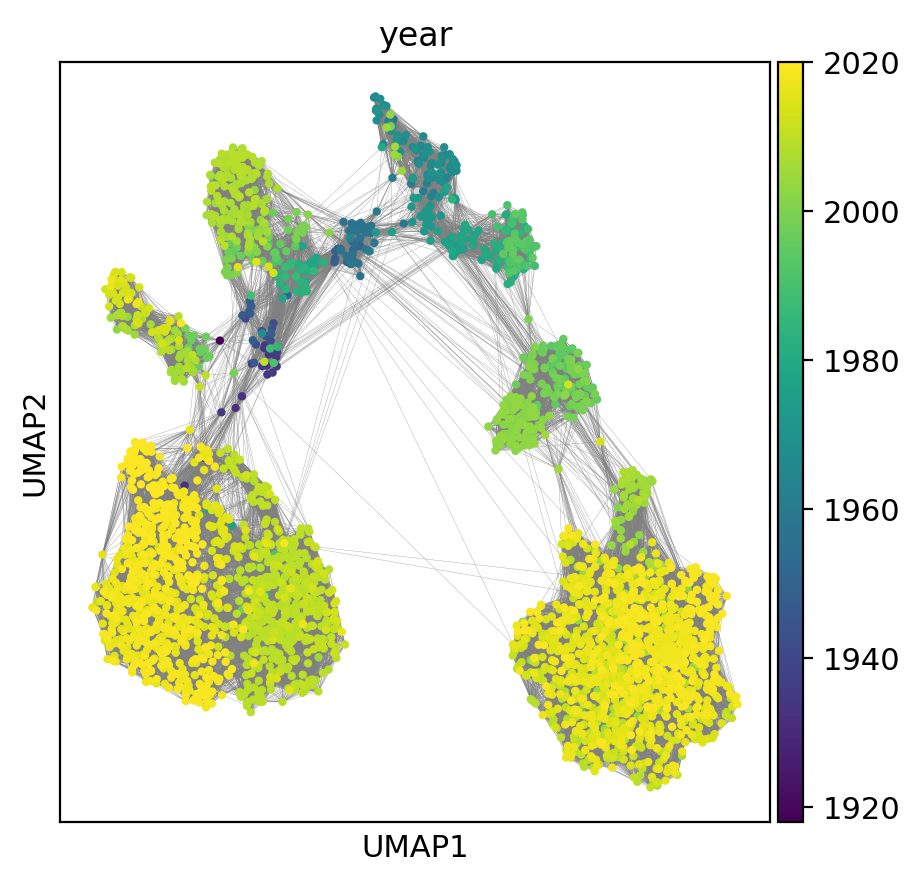

In [7]:
evo.set_figure_params(dpi_save=500, figsize=(5, 5))
sc.pl.umap(adata, color='year', edges=True,)

We can also color the same UMAP according to subtype:

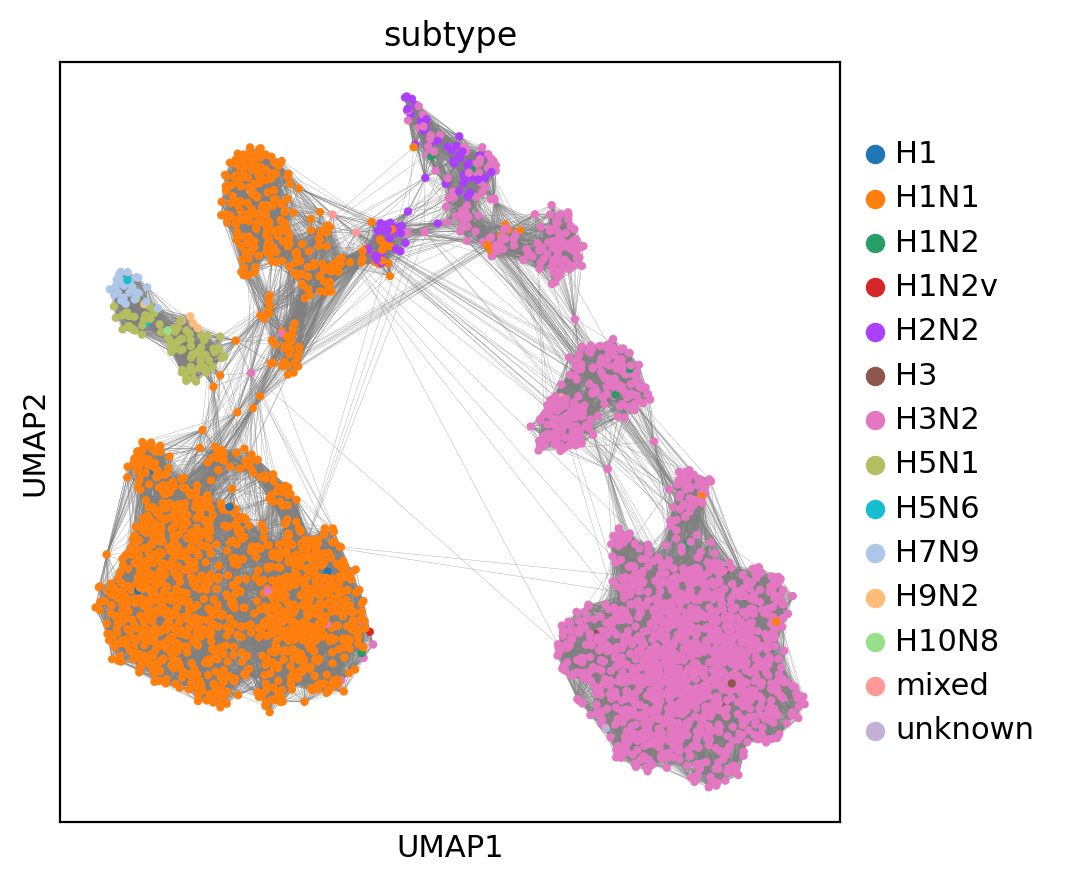

In [6]:
sc.pl.umap(adata, color='subtype', edges=True,)

Now we need to install and download the [ESM-1b](https://github.com/facebookresearch/esm) language model. We first install the package:

In [8]:
!pip install fair-esm

Now we need to use evolocity to compute scores for each edge in the nearest neighbors graph.

The command below is the most time-consuming step of this tutorial. First, the command below will download ESM-1b (which takes about 25 minutes).

Then, it will compute the sequence likelihoods and the velocity scores. **Likelihood computation runs much faster with GPU hardware acceleration** (which you can set by going to "Edit" -> "Notebook settings"). Likelihood computation takes about 25 minutes (on a GPU) and score computation takes about 40 minutes.

In [9]:
evo.tl.velocity_graph(adata)

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1b_t33_650M_UR50S.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm1b_t33_650M_UR50S-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S-contact-regression.pt
  0%|          | 0/3304 [00:00<?, ?it/s]

100%|██████████| 3304/3304 [38:49<00:00,  1.42it/s]


Now, we can project the velocities into two-dimensional UMAP space and visualize as a streamplot:

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


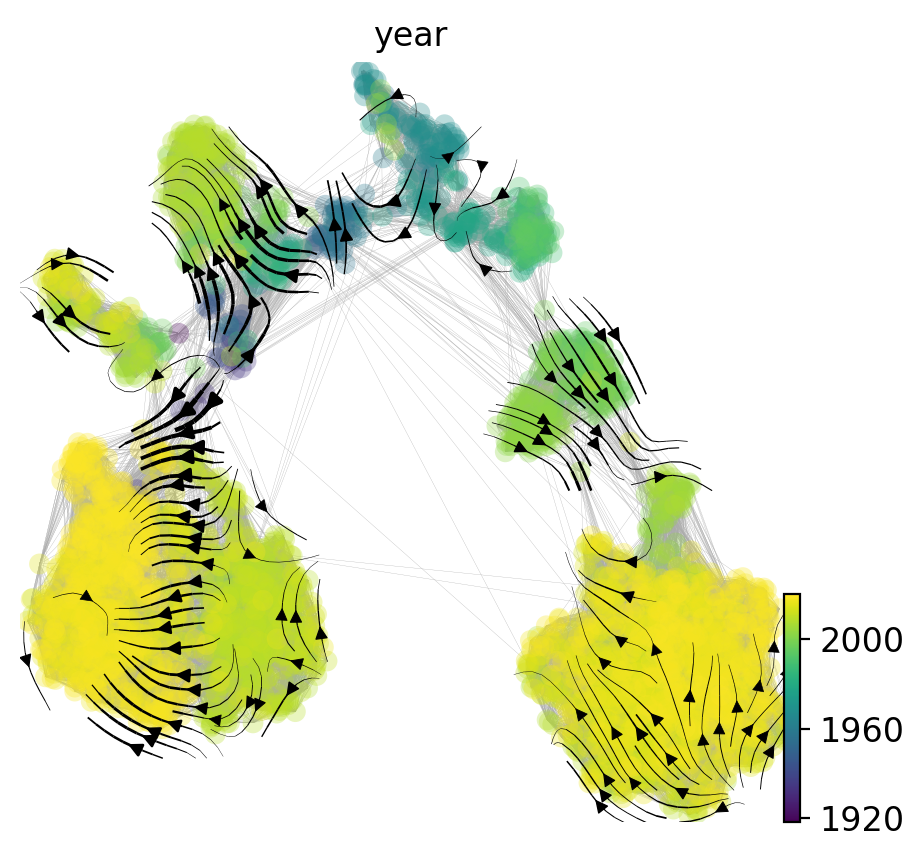

In [15]:
evo.tl.velocity_embedding(adata, basis='umap', scale=1.)
ax = evo.pl.velocity_embedding_stream(
    adata, basis='umap', min_mass=4., smooth=1., density=1.2,
    color='year', show=False,
)
sc.pl._utils.plot_edges(ax, adata, 'umap', 0.1, '#aaaaaa')

We can also compute terminal states (the root and end nodes) according to a diffusion process and visualize them:

computing terminal states
    identified 7 regions of root nodes and 5 regions of end points .
    finished (0:00:00) --> added
    'root_nodes', root nodes of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


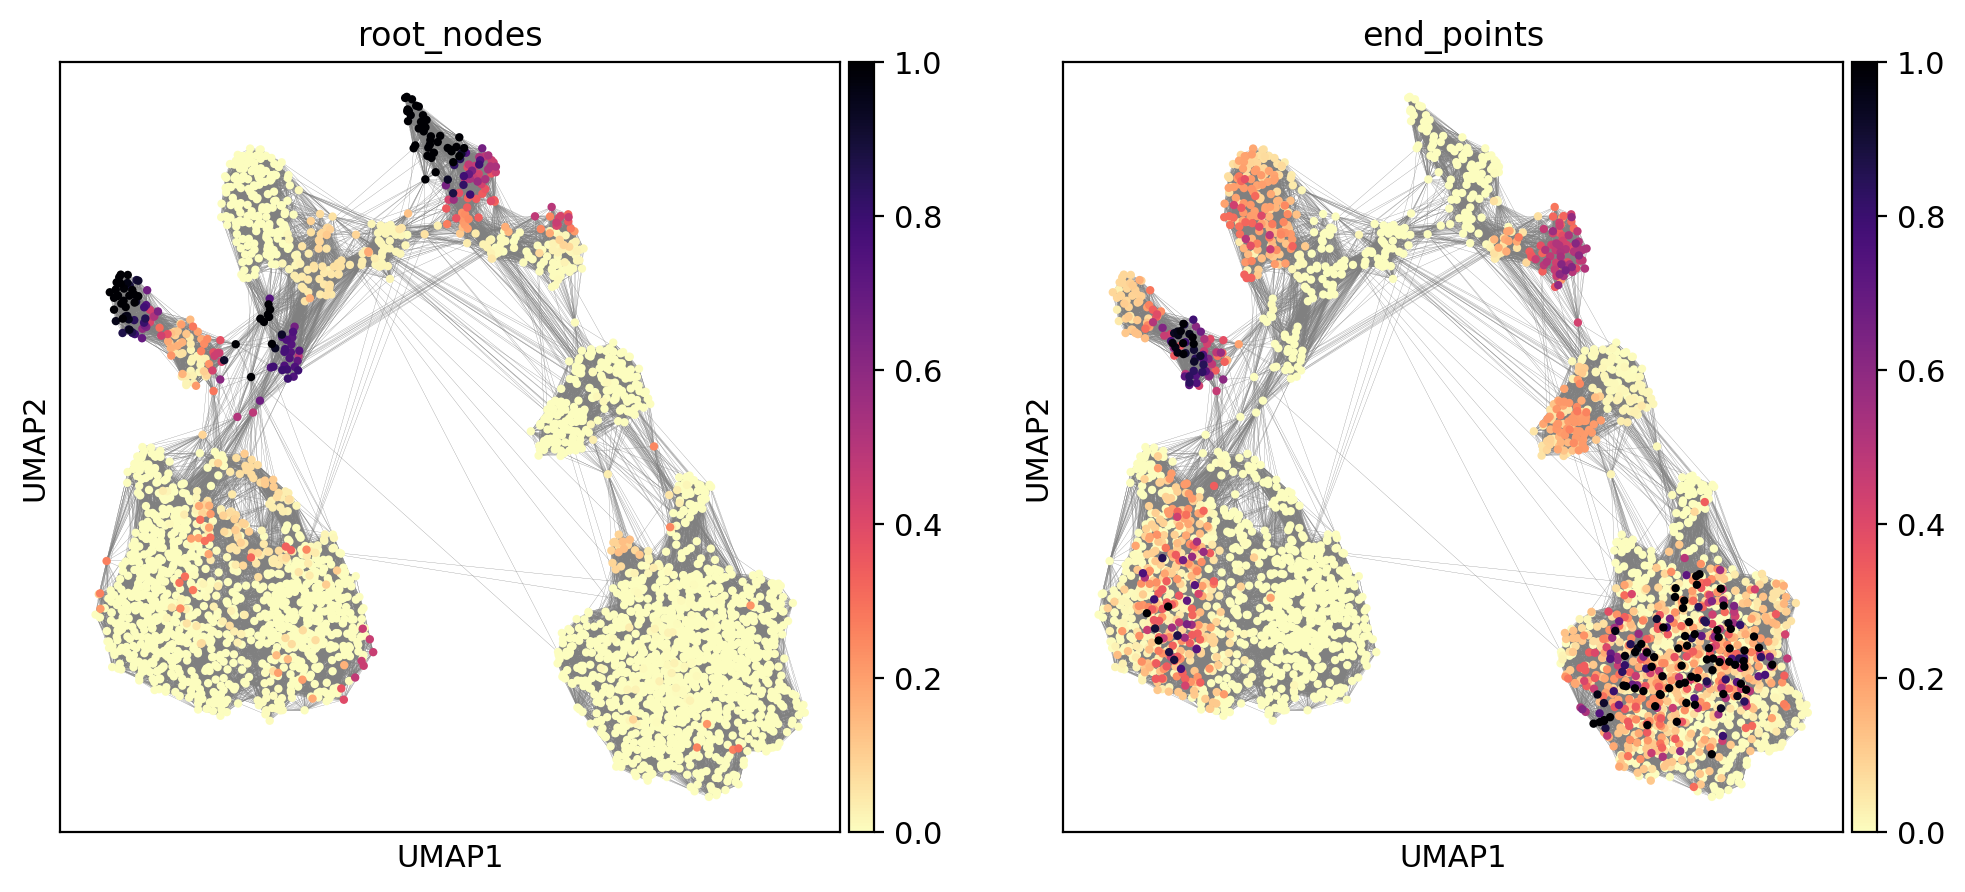

In [38]:
evo.tl.terminal_states(adata)
sc.pl.umap(
    adata, color=[ 'root_nodes', 'end_points' ],
    color_map=plt.cm.get_cmap('magma').reversed(),
    edges=True,
)

Now, we can use the root nodes to compute and visualize diffusion pseudotime on the graph:

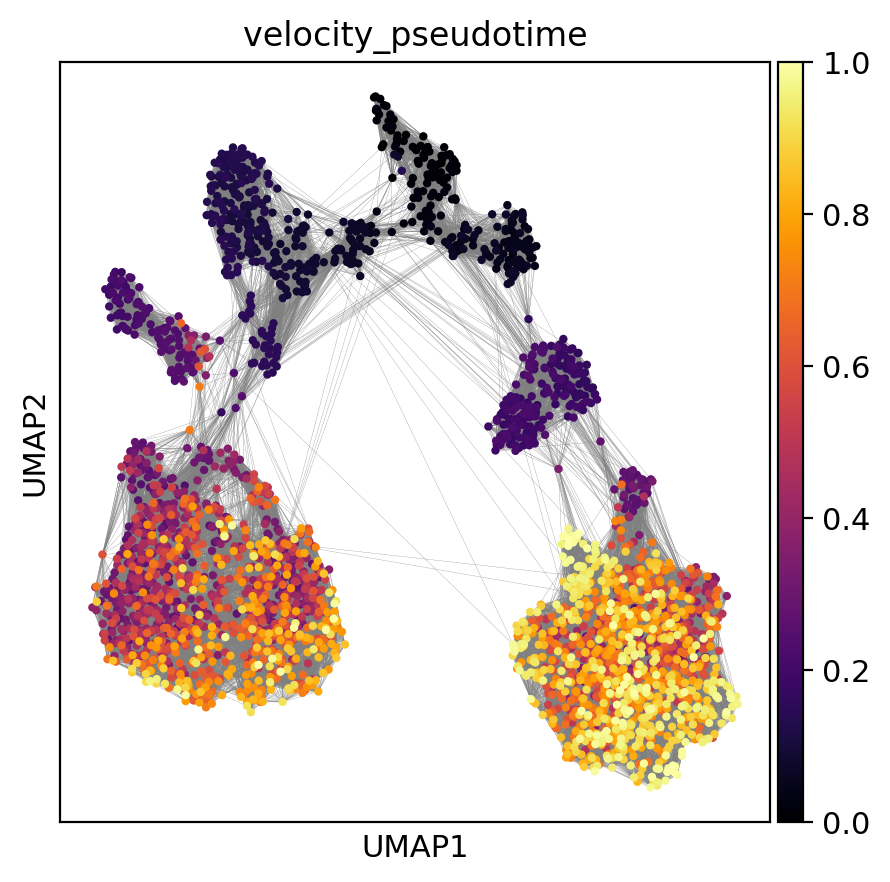

In [39]:
evo.tl.velocity_pseudotime(adata)
sc.pl.umap(
    adata, color='velocity_pseudotime', edges=True, cmap='inferno',
)

Finally, we can compute the correlation between pseudotime and sampling time to confirm that evolocity captures the temporal evolution of nucleoprotein!

In [40]:
nnan_idx = (np.isfinite(adata.obs['year']) &
            np.isfinite(adata.obs['velocity_pseudotime']))

adata_nnan = adata[nnan_idx]

print('Pseudotime-time Spearman r = {}, P = {}'
      .format(*ss.spearmanr(adata_nnan.obs['velocity_pseudotime'],
                            adata_nnan.obs['year'],
                            nan_policy='omit')))

Pseudotime-time Spearman r = 0.48792075278872044, P = 4.1389753064609613e-197
